In [6]:
import torch
import torch.nn as nn
import sys
from pathlib import Path

sys.path.insert(0, Path("").resolve().parent.parent.as_posix())
from utils import dl_utils

## 批量规范化层

In [7]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

        # 训练模式下使用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var


class BatchNorm(nn.Module):
    # num_feature: 完全连接层的输出数量或卷积层的输出通道数。
    # num_dims: 2表示完全连接层，4表示卷积层
    def __init__(self, num_feature, num_dims) -> None:
        super().__init__()
        if num_dims == 2:
            shape = (1, num_feature)
        else:
            shape = (1, num_feature, 1, 1)

        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        return Y

## 使用批量规范化层的 LeNet

In [8]:
lenet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

In [9]:
import torchvision
from torch.utils import data
from torchvision import transforms


def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=dl_utils.get_dataloader_workers()),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=dl_utils.get_dataloader_workers()),
    )

train loss 0.002, train acc 0.817, test loss 0.658, test acc 0.796
40228.3 examples/sec on cuda:0


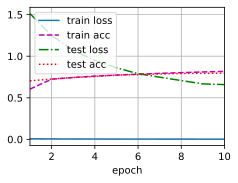

In [11]:
lr, num_epochs, batch_size = 1.0, 10, 256 
train_iter, test_iter = load_data_fashion_mnist(batch_size) 
lr, num_epochs = 0.01, 10
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet.parameters(), lr=lr)
dl_utils.train(lenet, train_iter, test_iter, loss, num_epochs, optimizer)

### 第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta

In [12]:
lenet[1].gamma.reshape((-1,)), lenet[1].beta.reshape((-1,))

(tensor([1.0234, 1.0029, 1.0560, 1.0976, 1.0190, 0.9884], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-0.0745, -0.0845, -0.0142,  0.0102, -0.1176,  0.0688], device='cuda:0',
        grad_fn=<ViewBackward0>))